In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

import cv2
import numpy as np
import matplotlib.pyplot as plt

import yaml

import sys
path_to_repo = "/home/d-shlenskii/repositories/resshift-continuous-in-time"
sys.path.append(path_to_repo)

from utils import instantiate_from_config, prepare_model
from samplers import EulerSampler

In [3]:
def plot_tensor(out):
    out = (out[0].permute(1, 2, 0).detach().cpu().numpy() + 1.) * 0.5
    plt.imshow(out)
    plt.show()

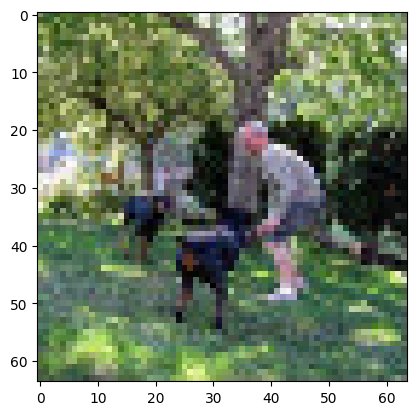

In [4]:
im = cv2.imread(f"{path_to_repo}/testdata/Val_SR/lq/ILSVRC2012_val_00000134.png")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

In [5]:
with open("pgd.yaml") as file:
    config = yaml.safe_load(file)

ae_config = config["autoencoder"]
ae_config["ckpt_path"] = f"{path_to_repo}/{ae_config['ckpt_path']}"
ae = instantiate_from_config(ae_config)
ae = prepare_model(ae, ae_config)

model_config = config["model"]
model_config["ckpt_path"] = f"{path_to_repo}/{model_config['ckpt_path']}"
model = instantiate_from_config(model_config)
model = prepare_model(model, model_config)
model.cuda()

device = "cuda" if torch.cuda.is_available() else "cpu"

sampler = EulerSampler(ae=ae, x0_pred_fn=model, device=device)

No module 'xformers'. Proceeding without it.
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.


/home/d-shlenskii/miniconda3/envs/default/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/d-shlenskii/miniconda3/envs/default/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


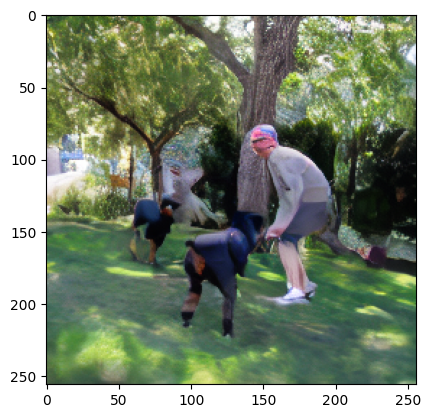

In [6]:
timesteps = torch.tensor(list(np.linspace(0, 1, 16))[::-1])
lq = ((torch.tensor(im).permute(2, 0, 1)[None] / 255.) - 0.5) / 0.5

out = sampler(timesteps, lq)

plot_tensor(out)